# Visualising the embedding space of CLIP

This notebook visualises the PCA- or t-SNE- transformed embedding space of CLIP for two settings:
* vanilla: visualising unrelated 10 image and 10 object category embeddings,
* best_match: visualising the best-matching image and object category pair for a specific image.

Note: We assume that you have caches these files, in their corresponding directory:
* image embeddings dictionary (keys=image ids, values=image embeddings): '../data/cache/image_emb.pickle'
* object embeddings numpy array: '../data/cache/object_emb.npy'
* object names text file: '../data/cache/object_texts.txt'
* places names text file: '../data/cache/place_texts.txt'

### Set-up

In [1]:
# Loading the required packages
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import random
%matplotlib inline
# If you want to view plots interactively, please uncomment the following line
# %matplotlib notebook 

# Analysis-specific packages
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Loading image and object embeddings

In [2]:
# Image embeddings
img_emb_path = '../data/cache/image_emb.pickle'

with open(img_emb_path, 'rb') as f:
    img_emb = pickle.load(f)

clip_feat_dim = 768
img_feats = np.zeros((len(img_emb.keys()), clip_feat_dim), dtype=np.float32)
img_texts = []

for ix, (img_id, emb) in enumerate(img_emb.items()):
    img_feats[ix, :] = emb
    img_texts.append(str(img_id))

In [3]:
# Object category embeddings
obj_emb_path = '../data/cache/object_emb.npy'
obj_txt_path = '../data/cache/object_texts.txt'
plc_txt_path = '../data/cache/place_texts.txt'

object_feats = np.load(obj_emb_path)
with open(obj_txt_path) as fid:
    object_texts = fid.readlines()
with open(plc_txt_path) as fid:
    place_texts = fid.readlines()   

# Remove redundant categories
object_texts = [o for o in list(set(object_texts)) if o not in place_texts] 

## PCA and t-SNE on the embedding space of CLIP corresponding to object embeddings 
### Helper functions

In [4]:
def generate_colors(n):
    '''This function generates a list of random n colors'''
    colors = []
    for _ in range(10):
        # Generate a random RGB value for each color
        r = random.random()
        g = random.random()
        b = random.random()
        color = (r, g, b)
        colors.append(color)
    return colors


def produce_items_for_analysis(approach):
    '''This function produces color lists, embedding matrices and 
       items to analyse lists (image ids and object categories)'''
    
     # Consider possibly unrelated images and words
    if approach == 'vanilla':
        # Choose number of images/object categories to plot
        n = 25
        
        # Color-wise, there are 10 images and then 10 objects 
        cols = n*['blue'] + n*['orange']

        # Every row is an embedding vector of one object or image
        embeddings = np.vstack((object_feats[:n, :], img_feats[:n, :]))
        items_to_analyse = object_texts[:n] + img_texts[:n]

    # Consider images with a best match words
    elif approach == 'best_match':
        # Choose number of images/object categories to plot
        n = 10

        # Color-wise, there are 10 images and then 10 objects
        cols = generate_colors(n)
        cols = cols + cols

        embeddings = img_feats[:n, :]
        items_to_analyse = img_texts[:n]

        # ixs = np.random.choice(img_feats.shape[0], n)
        # print(ixs)

        for ix in range(n):
            results_vec = object_feats @ img_feats[ix].T
            best_match_ix = np.where(results_vec == sorted(results_vec, reverse=True)[0])
            best_match_ix = int(best_match_ix[0])
            embeddings = np.vstack((embeddings, object_feats[best_match_ix, :].squeeze()))
            items_to_analyse.append(object_texts[best_match_ix]) 
    
    return cols, embeddings, items_to_analyse


def embeddings_normalizer(embeddings):
    '''This function normalises the input embeddings.'''
    return (embeddings - np.mean(embeddings, axis=0)) / np.std(embeddings, axis=0)


def perform_analysis(normalized_embeddings, num_dimensions):
    '''This functions performs t-SNE or PCA, depending on the number of input dimensions.'''
    
    if num_dimensions == 2:
        print('Performing t-SNE...')
        
        # Use t-SNE for 2D visualization
        tsne = TSNE(n_components=num_dimensions, perplexity=5.0)
        reduced_embeddings = tsne.fit_transform(normalized_embeddings)
    
    else:
        print('Performing PCA...')
        
        # Use PCA for higher-dimensional visualization
        pca = PCA(n_components=num_dimensions)
        reduced_embeddings = pca.fit_transform(normalized_embeddings)
    
    return reduced_embeddings


def visualizer(data_dict, emb_dict, num_dimensions):
    '''
    This function visualizes the two transformed data settings and saves them in one figure
    
    Input: 
        data (dictionary)
        transformed embeddings (dictionary)
        num_dimensions (number of dimensions of the transformed embeddings)
    Output: 
        figure (.png)
    '''
    # 2D
    if num_dimensions == 2:
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cols)

        # Annotate the plot with the labels
        for i, label in enumerate(items_to_analyse):
            plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

        # Add labels and title to the plot
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.title('t-SNE Visualization')

        
        
        # Show and save the figure
        plt.show()
        plt.savefig('pca.png', bbox_inches='tight')
        
        
        
    # 3D and more dimen
    elif num_dimensions != 2:
        if num_dimensions != 3:
            print('Visualising 3D, even though your embedding space has more than 3 dimensions...')

        approaches = list(data_dict.keys())
        
        # Create a figure and two subplots
        fig, axes = plt.subplots(1, len(approaches), subplot_kw={'projection': '3d'}, figsize=(16, 25))

        # Iterate over the axes and plot on each
        for i, ax in enumerate(axes):
            approach = approaches[i]
            
            cols, _, items_to_analyse = data_dict[approach]
            reduced_embeddings = emb_dict[approach]
            
            xdata = reduced_embeddings[:, 0]
            ydata = reduced_embeddings[:, 1]
            zdata = reduced_embeddings[:, 2]
            ax.scatter3D(xdata, ydata, zdata, c=cols, s=250)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
        
            if approach == 'best_match':
                for i, text in enumerate(items_to_analyse):
                    ax.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], text, fontsize=7)

        # Adjust spacing between subplots
        plt.tight_layout()

        # Show and save the figure
        plt.show()
        fig.savefig('../blogpost_images/pca.png', bbox_inches='tight')
    

### Perform the pipeline

In [5]:
def main():
    
    # Step 1: Have relevant CLIP embeddings for the image and object data
    data_dict = {
        'vanilla': produce_items_for_analysis('vanilla'),
        'best_match': produce_items_for_analysis('best_match')
    }
    
    # Step 2: Choose the number of dimensions
    num_dimensions = 3

    # Step 3: Generate the transformed embeddings
    emb_dict = {}
    for approach, (cols, embeddings, items_to_analyse) in data_dict.items():
        # Normalize the embeddings
        normalized_embeddings = embeddings_normalizer(embeddings)
        
        # Perform PCA or t-SNE
        emb_dict[approach] = perform_analysis(normalized_embeddings, num_dimensions)
    
    # Step 4: Visualize and save the results
    visualizer(data_dict, emb_dict, num_dimensions)

Performing PCA...
Performing PCA...


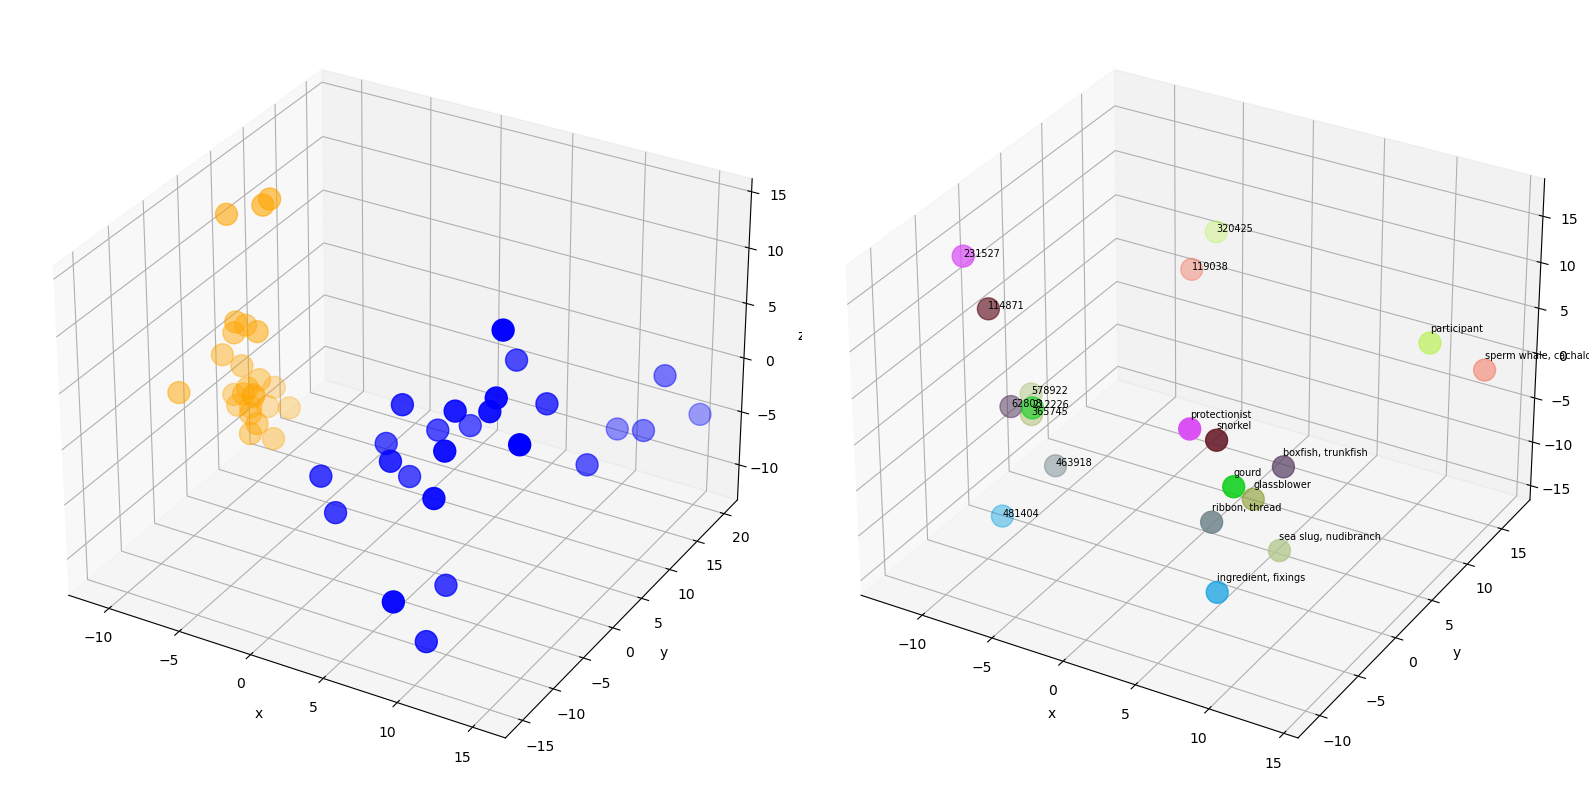

In [6]:
if __name__ == "__main__":
    main()

Working with PCA or t-SNE would probably require us to set some threshold on the similarity between two words to determine whether they are synonyms:
* For example by taking dot product/cosine similarities between the embeddings of the two objects.

\
           
1. One way out of this is to perform clustering (k-means/Gaussian mixtures)
    * Drawback: need to set k, and this would have to be informed by the dataset for the objects/places we are using

\

2. Another possibility would be to not do a PCA or t-SNE but instead do a search through the combinations of the first n most fitting descriptor words and pick one combination that would produce the highest similarity with the image
    * Brute-force search: computationally intensive
    * Searching among the centroids created by clustering the objects

\

This method could not work for images that contain a lot of similar objects (say, three different kinds of fruit), since we would filter similar words being captioned simultaneously.